# Process True False Dataset

Dataset from the paper [The Internal State of an LLM Knows When It's Lying](https://aclanthology.org/2023.findings-emnlp.68.pdf)

You can download the dataset [here](http://azariaa.com/Content/Datasets/true-false-dataset.zip).

In [1]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

from sklearn.metrics.pairwise import cosine_similarity

from utils import add_split_column

device = "cuda" if torch.cuda.is_available() else "CPU"
print(f'Device: {device}')

Device: cuda


In [2]:
dataset_name = 'true-false-dataset'
categories = ['animals', 'cities', 'companies', 'elements', 
              'facts', 'generated', 'inventions']
only_train = True

data_path = f'../Data/{dataset_name}'
embeddings_path = f'Embeddings/{dataset_name}'
concepts_path = f'Concepts/{dataset_name}'
cos_sims_path = f'Cosine_Similarities/{dataset_name}'
images_path = f'Images/{dataset_name}'

In [3]:
embeddings_file = os.path.join(embeddings_path, 'embeddings.pt')
    
if os.path.exists(embeddings_file):
    print('Embeddings file found. No need to load model and tokenizer.')
    model = None
    tokenizer = None
else:
    print('Embeddings file NOT found. Loading model and tokenizer...')
    
    from huggingface_hub import notebook_login
    notebook_login()
    
    model_name_or_path = "meta-llama/Meta-Llama-3-8B-Instruct"
    
    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"
    
    model = AutoModelForCausalLM.from_pretrained(model_name_or_path)
    model.to(device)
    model.eval()
    print('Done.')

Embeddings file found. No need to load model and tokenizer.


## Processing statements

In [4]:
def get_category(category, data_path):
    cat_path = os.path.join(data_path, f'{category}_true_false.csv')
    df_cat = pd.read_csv(cat_path)
    df_cat[category] = 1
    return df_cat

In [5]:
def get_categories(categories, data_path):
    df_list = []
    for category in categories:
        df_cat = get_category(category, data_path=data_path)
        df_list.append(df_cat)
    metadata_df = pd.concat(df_list, ignore_index=True)
    metadata_df = metadata_df.fillna(0)
    for category in categories:
        metadata_df[category] = metadata_df[category].astype(int)
    metadata_df = metadata_df.rename(columns={'label': 'true'})
    return metadata_df

In [6]:
def get_hidden_states(statements, model, tokenizer, embeddings_path, 
                      device=device, save=True):
    embeddings_file = os.path.join(embeddings_path, 'embeddings.pt')
    
    if os.path.exists(embeddings_file):
        print('   Hidden states file found.')
        hidden_states = torch.load(embeddings_file)
    else:
        print('   Hidden states file NOT found.')
        hidden_states = []
        for statement in tqdm(statements, desc='Getting hidden states'):
            tokenized_prompt = tokenizer(statement, return_tensors="pt").to(device)
            output = model(**tokenized_prompt, output_hidden_states=True)
            
            features = output.hidden_states[-1][0][-1]
            hidden_state = features.cpu().detach()
            hidden_states.append(hidden_state)
            
            del output
            del features
            torch.cuda.empty_cache()

        hidden_states = torch.stack(hidden_states, dim=0)
        # Center embeddings
        average_embedding = torch.mean(hidden_states, 0) 
        centered_hidden_states = hidden_states - average_embedding
        if save:
            os.makedirs(embeddings_path, exist_ok=True)
            torch.save(hidden_states, embeddings_file)
            
    return hidden_states

In [7]:
def process_data(categories, model, tokenizer, data_path, embeddings_path):
    print('Getting statements...', end=' ')
    metadata_df = get_categories(categories, data_path=data_path)
    metadata_df = add_split_column(metadata_df)
    metadata_df.to_csv(os.path.join(data_path, 'metadata.csv'), index=False)
    
    statements = metadata_df['statement'].to_list()

    train_mask = metadata_df['split'] == 'train'
    train_metadata_df = metadata_df[train_mask].reset_index(drop=True)
    train_metadata_df.to_csv(os.path.join(data_path, 'train_metadata.csv'), index=False)
    print('Done.')

    print('Getting hidden states...')
    hidden_states = get_hidden_states(statements, model, tokenizer, embeddings_path)
    train_hidden_states = hidden_states[train_mask]
    torch.save(train_hidden_states, os.path.join(embeddings_path, 'train_embeddings.pt'))
    print('Done.')

    return metadata_df, hidden_states

In [8]:
metadata_df, hidden_states = process_data(categories, model, tokenizer, data_path, embeddings_path)

Getting statements... Done.
Getting hidden states...
   Hidden states file found.
Done.


In [9]:
print(f'Number of statements: {metadata_df.shape[0]}')
print(f'Number of true statements: {metadata_df[metadata_df["true"] == 1].shape[0]}')
print(f'Number of false statements: {metadata_df[metadata_df["true"] == 0].shape[0]}')

Number of statements: 6330
Number of true statements: 3187
Number of false statements: 3143


## Computing concepts

In [10]:
def compute_single_concept(concept, metadata_df, hidden_states):
    # Get embeddings from the concept
    hidden_states_cat = hidden_states[metadata_df[concept]==1] 
    # Get average embedding
    concept_vect = torch.mean(hidden_states_cat, 0) 
    # Normalize vector
    concept_vect = concept_vect / concept_vect.norm() 
    return concept_vect

def compute_concepts(metadata_df, hidden_states, concepts_path, save=True, only_train=True):
    if only_train:
        train_mask = metadata_df['split'] == 'train'
        hidden_states = hidden_states[train_mask]
        metadata_df = metadata_df[train_mask].reset_index(drop=True)
    concept_names = list(metadata_df.columns[1:-1])
    concepts = {}

    print('Computing concept vectors...', end=' ')
    for concept in concept_names:
        concept_vect = compute_single_concept(concept, metadata_df, hidden_states)
        concepts[concept] = concept_vect
    print('Done.')
        
    if save:
        print('Saving concepts...', end=' ')
        os.makedirs(concepts_path, exist_ok=True)
        if only_train:
            concepts_path = os.path.join(concepts_path, 'train_concepts.pt')
        else:
            concepts_path = os.path.join(concepts_path, 'concepts.pt')
        torch.save(concepts, concepts_path)
        print('Done.')

    print(f'Concepts computed: {list(concepts.keys())}')
    return concepts

In [11]:
concepts = compute_concepts(metadata_df, hidden_states, concepts_path, only_train=only_train)

Computing concept vectors... Done.
Saving concepts... Done.
Concepts computed: ['true', 'animals', 'cities', 'companies', 'elements', 'facts', 'generated', 'inventions']


## Compute cosine similarities

In [12]:
def compute_cosine_sims(hidden_states, metadata_df, concept_embs, concept_names, cos_sims_path,
                        save=True, only_train=True):
    if only_train:
        train_mask = metadata_df['split'] == 'train'
        hidden_states = hidden_states[train_mask]
        metadata_df = metadata_df[train_mask].reset_index(drop=True)
    print('Computing cosine similarities...', end=' ')
    similarities = cosine_similarity(hidden_states, concept_embs)
    cosine_similarity_df = pd.DataFrame(similarities, columns=concept_names)
    print('Done.')
    if save:
        print('Saving cosine similarities...', end=' ')
        os.makedirs(cos_sims_path, exist_ok=True)
        if only_train:
            cos_sims_df_path = os.path.join(cos_sims_path, 'train_cosine_similarities.csv')
        else:
            cos_sims_df_path = os.path.join(cos_sims_path, 'cosine_similarities.csv')
        cosine_similarity_df.to_csv(cos_sims_df_path, index=False)
        print('Done.')
        
    return cosine_similarity_df

In [13]:
concept_embs = torch.stack(list(concepts.values()), dim=0)
concept_names = list(concepts.keys())
cosine_similarity_df = compute_cosine_sims(hidden_states, metadata_df, concept_embs, concept_names, cos_sims_path,
                                          only_train=only_train)

Computing cosine similarities... Done.
Saving cosine similarities... Done.


In [14]:
def plot_cos_sim_histograms(metadata_df, cosine_similarity_df, images_path, only_train=True):
    if only_train:
        train_mask = metadata_df['split'] == 'train'
        metadata_df = metadata_df[train_mask].reset_index(drop=True)
    concept_names = list(metadata_df.columns[1:-1])
    fig, axs = plt.subplots(2, 4, figsize=(8,4), sharex=True)
    bins = np.linspace(0, 1, 20)
    for i, concept in enumerate(concept_names):
        ix, iy = int(i/4), i%4
        sns.kdeplot(cosine_similarity_df[metadata_df[concept]==1][concept], 
                    label='In concept', ax=axs[ix,iy])
        sns.kdeplot(cosine_similarity_df[metadata_df[concept]==0][concept], 
                    label='Out of concept', ax=axs[ix,iy])
        axs[ix,iy].set_xlabel('')
        axs[ix,iy].set_ylabel('')
        axs[ix,iy].set_title(concept)
    
    handles, labels = axs[0,0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, bbox_to_anchor=(1.2, 0.9))
    xl = fig.supxlabel('Cosine Similarity')
    yl = fig.supylabel('Proportion of samples')
    title = fig.suptitle('Cosine similarity in/out of concept')
    fig.tight_layout()

    print('Saving image...', end=' ')
    os.makedirs(images_path, exist_ok=True)
    if only_train:
        cos_sims_image_path = os.path.join(images_path, 'train_cosine_similarities.png')
    else:
        cos_sims_image_path = os.path.join(images_path, 'cosine_similarities.png')
    fig.savefig(cos_sims_image_path, bbox_extra_artists=(lgd,xl,yl,title), 
                bbox_inches='tight')
    print('Done.')
    
    plt.show()

Saving image... Done.


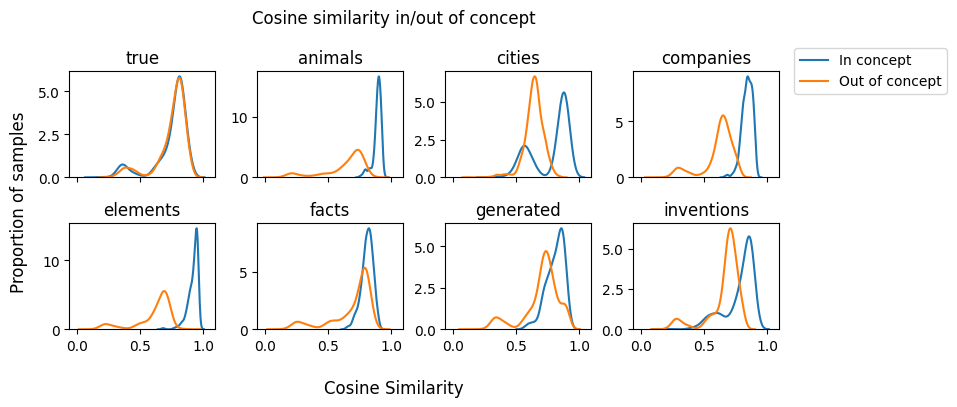

In [15]:
plot_cos_sim_histograms(metadata_df, cosine_similarity_df, images_path, only_train=only_train)

In [16]:
def show_similarity_concepts(concepts, images_path, only_train=True):
    concept_embs = torch.stack(list(concepts.values()), dim=0)
    concept_names = list(concepts.keys())
    cos_sim_concepts_df = compute_cosine_sims(concept_embs, 
                                              metadata_df,
                                              concept_embs, 
                                              concept_names, 
                                              '', only_train=False, save=False)
    cos_sim_concepts_df['Concept'] = list(concepts.keys())
    cos_sim_concepts_df = cos_sim_concepts_df.set_index('Concept')
    ax = sns.heatmap(cos_sim_concepts_df, annot=True, fmt=".2f", cmap="Blues",
               cbar_kws={'label': 'Cosine similarity'})
    ax.set_title('Cosine similarity between concepts')

    print('Saving image...', end=' ')
    os.makedirs(images_path, exist_ok=True)
    if only_train:
        cos_sims_image_path = os.path.join(images_path, 'train_cosine_similarities_concepts.png')
    else:
        cos_sims_image_path = os.path.join(images_path, 'cosine_similarities_concepts.png')
    plt.savefig(cos_sims_image_path)
    print('Done.')
    
    plt.show()

Computing cosine similarities... Done.
Saving image... Done.


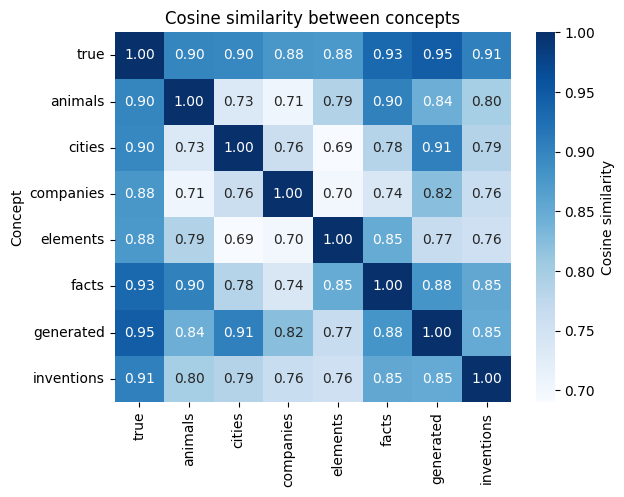

In [17]:
show_similarity_concepts(concepts, images_path, only_train)

## Concept presence models

In [18]:
train_metadata_df = pd.read_csv(os.path.join(data_path, 'train_metadata.csv'))
train_cosine_similarity_df = pd.read_csv(os.path.join(cos_sims_path, 'train_cosine_similarities.csv'))
train_hidden_states = torch.load(os.path.join(embeddings_path, 'train_embeddings.pt'))

### (M1) Cosine similarity global threshold

In [19]:
from models import get_global_threshold

m1_models, m1_global_train_error, m1_train_errors = get_global_threshold(train_metadata_df, train_cosine_similarity_df)
m1_train_errors['Model'] = '(M1) Global Threshold'

Global threshold: 0.833 | Train error: 0.127
Concept: true       | Train error: 0.490
Concept: animals    | Train error: 0.017
Concept: cities     | Train error: 0.088
Concept: companies  | Train error: 0.070
Concept: elements   | Train error: 0.009
Concept: facts      | Train error: 0.118
Concept: generated  | Train error: 0.155
Concept: inventions | Train error: 0.071


### (M2) Cosine similarity individual threshold

In [20]:
from models import get_individual_thresholds

m2_models, m2_train_errors = get_individual_thresholds(train_metadata_df, train_cosine_similarity_df)
m2_train_errors['Model'] = '(M2) Individual Threshold'

Concept: true       | Threshold: -0.528 | Train error: 0.499
Concept: animals    | Threshold: 0.836 | Train error: 0.017
Concept: cities     | Threshold: 0.809 | Train error: 0.080
Concept: companies  | Threshold: 0.784 | Train error: 0.017
Concept: elements   | Threshold: 0.820 | Train error: 0.007
Concept: facts      | Threshold: 0.879 | Train error: 0.092
Concept: generated  | Threshold: 0.933 | Train error: 0.043
Concept: inventions | Threshold: 0.819 | Train error: 0.064


### (M3) Global cosine similarity logistic regression

In [21]:
from models import get_global_similarity_log_reg

m3_models, m3_global_train_error, m3_train_errors = get_global_similarity_log_reg(train_metadata_df, 
                                                                                  train_cosine_similarity_df)
m3_train_errors['Model'] = '(M3) Global Similarity LogReg'

Global train error: 0.138
Concept: true       | Train error: 0.499
Concept: animals    | Train error: 0.023
Concept: cities     | Train error: 0.124
Concept: companies  | Train error: 0.126
Concept: elements   | Train error: 0.015
Concept: facts      | Train error: 0.093
Concept: generated  | Train error: 0.126
Concept: inventions | Train error: 0.102


### (M4) Cosine similarity logistic regression

In [22]:
from models import get_similarity_log_reg

m4_models, m4_train_errors = get_similarity_log_reg(train_metadata_df, train_cosine_similarity_df)
m4_train_errors['Model'] = '(M4) Individual Similarity LogReg'

Concept: true       | Train error: 0.520
Concept: animals    | Train error: 0.019
Concept: cities     | Train error: 0.082
Concept: companies  | Train error: 0.025
Concept: elements   | Train error: 0.010
Concept: facts      | Train error: 0.096
Concept: generated  | Train error: 0.043
Concept: inventions | Train error: 0.134


### (M5) Embeddings logistic regression

In [23]:
from models import get_embeddings_log_reg

m5_models, m5_train_errors = get_embeddings_log_reg(train_hidden_states, train_metadata_df, train_cosine_similarity_df)
m5_train_errors['Model'] = '(M5) Embeddings LogReg'

Concept: true       | Train error: 0.001
Concept: animals    | Train error: 0.000
Concept: cities     | Train error: 0.000
Concept: companies  | Train error: 0.000
Concept: elements   | Train error: 0.000
Concept: facts      | Train error: 0.000
Concept: generated  | Train error: 0.000
Concept: inventions | Train error: 0.000


## Comparing Models

### Train classification error

In [24]:
error_comparison_df = pd.DataFrame.from_dict([m1_train_errors, 
                                              m2_train_errors,
                                              m3_train_errors,
                                              m4_train_errors,
                                              m5_train_errors
                                             ])
error_comparison_df = error_comparison_df.set_index('Model')
error_comparison_df

,true,animals,cities,companies,elements,facts,generated,inventions
Model,,,,,,,,
(M1) Global Threshold,0.489898,0.017318,0.087641,0.070060,0.008922,0.118342,0.155077,0.070585
(M2) Individual Threshold,0.498819,0.017318,0.079507,0.016531,0.006822,0.092102,0.042771,0.063500
(M3) Global Similarity LogReg,0.499082,0.023353,0.124114,0.126214,0.015219,0.092627,0.125689,0.101548
(M4) Individual Similarity LogReg,0.520073,0.019155,0.082131,0.025453,0.009709,0.096300,0.042771,0.134086
(M5) Embeddings LogReg,0.001050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Test classification metrics

In [25]:
from utils import get_all_models_classification_metric

metadata_df = pd.read_csv(os.path.join(data_path, 'metadata.csv'))
cosine_similarity_df = pd.read_csv(os.path.join(cos_sims_path, 'cosine_similarities.csv'))
hidden_states = torch.load(os.path.join(embeddings_path, 'embeddings.pt'))

test_mask = metadata_df['split'] == 'test'
test_hidden_states = hidden_states[test_mask]
test_metadata_df = metadata_df[test_mask].reset_index(drop=True)
test_cosine_similarity_df = cosine_similarity_df[test_mask].reset_index(drop=True)

In [26]:
print('Test Accuracy')
models = {'(M1) Global Threshold': m1_models,
          '(M2) Individual Threshold': m2_models,
          '(M3) Global Similarity LogReg': m3_models,
          '(M4) Individual Similarity LogReg': m4_models,
          '(M5) Embeddings LogReg': m5_models
         }
acc_df = get_all_models_classification_metric(models, test_metadata_df, test_cosine_similarity_df,
                                         test_hidden_states, metric='accuracy')
acc_df

Test Accuracy


,true,animals,cities,companies,elements,facts,generated,inventions
Model,,,,,,,,
(M1) Global Threshold,0.528242,0.982498,0.901352,0.920446,0.994431,0.876691,0.823389,0.922832
(M2) Individual Threshold,0.499602,0.981702,0.913286,0.982498,0.993636,0.910103,0.972156,0.926014
(M3) Global Similarity LogReg,0.506762,0.976134,0.863166,0.867144,0.988862,0.911695,0.866348,0.890215
(M4) Individual Similarity LogReg,0.485282,0.979316,0.908512,0.974543,0.992045,0.908512,0.971360,0.863166
(M5) Embeddings LogReg,0.859189,0.998409,1.000000,0.999204,0.999204,0.997613,0.996022,0.998409


In [27]:
print('Test F1')
f1_df = get_all_models_classification_metric(models, test_metadata_df, test_cosine_similarity_df,
                                         test_hidden_states, metric='f1')
f1_df

Test F1


,true,animals,cities,companies,elements,facts,generated,inventions
Model,,,,,,,,
(M1) Global Threshold,0.347635,0.942105,0.755906,0.750000,0.979472,0.329004,0.090164,0.625483
(M2) Individual Threshold,0.666313,0.938667,0.793169,0.954357,0.976608,0.050420,0.054054,0.656827
(M3) Global Similarity LogReg,0.150685,0.915730,0.624454,0.498498,0.957831,0.165414,0.066667,0.361111
(M4) Individual Similarity LogReg,0.440795,0.928962,0.778420,0.931624,0.970414,0.000000,0.000000,0.054945
(M5) Embeddings LogReg,0.860300,0.994792,1.000000,0.998004,0.997101,0.986900,0.927536,0.994382


In [28]:
print('Test AUC')
auc_df = get_all_models_classification_metric(models, test_metadata_df, test_cosine_similarity_df,
                                         test_hidden_states, metric='auc')
auc_df

Test AUC


,true,animals,cities,companies,elements,facts,generated,inventions
Model,,,,,,,,
(M1) Global Threshold,-,-,-,-,-,-,-,-
(M2) Individual Threshold,-,-,-,-,-,-,-,-
(M3) Global Similarity LogReg,0.519903,0.996876,0.740475,0.994526,0.999595,0.776631,0.695172,0.785897
(M4) Individual Similarity LogReg,0.480097,0.996876,0.740475,0.994526,0.999595,0.776631,0.695172,0.785897
(M5) Embeddings LogReg,0.935117,1.0,1.0,1.0,1.0,0.99997,0.99975,0.999995


In [29]:
print('Test K1')
k1_df = get_all_models_classification_metric(models, test_metadata_df, test_cosine_similarity_df,
                                         test_hidden_states, metric='K1')
k1_df

Test K1


,true,animals,cities,companies,elements,facts,generated,inventions
Model,,,,,,,,
(M1) Global Threshold,-,-,-,-,-,-,-,-
(M2) Individual Threshold,-,-,-,-,-,-,-,-
(M3) Global Similarity LogReg,0.240108,0.788223,0.756121,0.806444,0.832084,0.699132,0.778846,0.764386
(M4) Individual Similarity LogReg,0.016024,0.824228,0.681731,0.785656,0.850578,0.812315,0.928599,0.774117
(M5) Embeddings LogReg,0.472079,0.847292,0.74941,0.800823,0.862343,0.908792,0.971186,0.858793


In [30]:
print('Test K2')
k2_df = get_all_models_classification_metric(models, test_metadata_df, test_cosine_similarity_df,
                                         test_hidden_states, metric='K2')
k2_df

Test K2


,true,animals,cities,companies,elements,facts,generated,inventions
Model,,,,,,,,
(M1) Global Threshold,-,-,-,-,-,-,-,-
(M2) Individual Threshold,-,-,-,-,-,-,-,-
(M3) Global Similarity LogReg,0.084383,0.670079,0.598735,0.698249,0.739606,0.536643,0.631871,0.609061
(M4) Individual Similarity LogReg,0.0003,0.749161,0.494578,0.699977,0.802291,0.677796,0.862467,0.62147
(M5) Embeddings LogReg,0.373316,0.846659,0.749373,0.800624,0.861494,0.90688,0.969358,0.85711


In [31]:
print('Test Kmax')
kmax_df = get_all_models_classification_metric(models, test_metadata_df, test_cosine_similarity_df,
                                         test_hidden_states, metric='Kmax')
kmax_df

Test Kmax


,true,animals,cities,companies,elements,facts,generated,inventions
Model,,,,,,,,
(M1) Global Threshold,-,-,-,-,-,-,-,-
(M2) Individual Threshold,-,-,-,-,-,-,-,-
(M3) Global Similarity LogReg,0.089445,0.385266,0.544559,0.557195,0.502376,0.279743,0.272849,0.322384
(M4) Individual Similarity LogReg,0.009994,0.638588,0.324855,0.605555,0.787507,0.425463,0.9244,0.342734
(M5) Embeddings LogReg,0.398265,0.8456,0.749388,0.800316,0.86233,0.907569,0.968881,0.85676
